借鉴网址： https://github.com/ComputationalDomain/PINNs/tree/main/Cylinder-Wake

代码中使用到的mat文件也是从上述网址下载。

偏微分方程：

$$F_1: \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} + \frac{\partial p}{\partial x} - \nu (\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}) = 0 \\ F_2: \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + \frac{\partial p}{\partial y} - \nu (\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}) = 0 \\ F_3: \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0 \quad (\text{Continuity})$$



定义了 $\nu = 0.01$，这是圆柱绕流常用的雷诺数 $Re=100$ 对应的粘性系数（假设特征长度和速度为 1）。

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# 定义一个简单的神经网络模型
class NavierStokersPINN(nn.Module):
    def __init__(self, layers=[3, 128, 128, 128, 128, 3]):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            nn.init.kaiming_normal_(self.layers[-1].weight)
            nn.init.zeros_(self.layers[-1].bias)
        self.activation = nn.Tanh()


    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

In [ ]:
# 构造物理损失
nu = 0.01


# 直观的PDE loss是我写的这个，但是程序实现上有问题，不能运行，所以注释掉了
# 保留下来是为了之后更好的理解，能够运行的是后面不注释的那个
# def pde_residual(X, U):
#     # X: (batch_size, 3), X = [x, y, t]
#     # U: (batch_size, 3), U = [u, v, p]
#     u, v, p = U[:, 0], U[:, 1], U[:, 2]
#     # x, y, t = X[:, 0], X[:, 1], X[:, 2]
#     # 🌟 关键修改：通过克隆并设置 requires_grad=True，确保 x, y, t 是独立的叶子节点
#     # 且可被求导，但不再是 X 的视图。
#     x = X[:, 0].clone().requires_grad_(True)
#     y = X[:, 1].clone().requires_grad_(True)
#     t = X[:, 2].clone().requires_grad_(True)

#     du_dt = torch.autograd.grad(u, t, torch.ones_like(t), create_graph=True)[0]
#     du_dx = torch.autograd.grad(u, x, torch.ones_like(x), create_graph=True)[0]
#     du_dy = torch.autograd.grad(u, y, torch.ones_like(y), create_graph=True)[0]
#     dp_dx = torch.autograd.grad(p, x, torch.ones_like(x), create_graph=True)[0]
#     d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(x), create_graph=True)[0]
#     d2u_dy2 = torch.autograd.grad(du_dy, y, torch.ones_like(y), create_graph=True)[0]

#     dv_dt = torch.autograd.grad(v, t, torch.ones_like(t), create_graph=True)[0]
#     dv_dx = torch.autograd.grad(v, x, torch.ones_like(x), create_graph=True)[0]
#     dv_dy = torch.autograd.grad(v, y, torch.ones_like(y), create_graph=True)[0]
#     dp_dy = torch.autograd.grad(p, y, torch.ones_like(y), create_graph=True)[0]
#     d2v_dx2 = torch.autograd.grad(dv_dx, x, torch.ones_like(x), create_graph=True)[0]
#     d2v_dy2 = torch.autograd.grad(dv_dy, y, torch.ones_like(y), create_graph=True)[0]

#     # Navier-Stokes equations
#     # Momentum equation
#     F1 = du_dt + u * du_dx + v * du_dy + dp_dx - nu * (d2u_dx2 + d2u_dy2)
#     F2 = dv_dt + u * dv_dx + v * dv_dy + dp_dy - nu * (d2v_dx2 + d2v_dy2)
#     # Continuity
#     F3 = du_dx + dv_dy

#     return F1, F2, F3

def pde_residual(X, U):
    # X: (batch_size, 3), X = [x, y, t]
    # U: (batch_size, 3), U = [u, v, p]
    u, v, p = U[:, 0], U[:, 1], U[:, 2]
    x, y, t = X[:, 0:1], X[:, 1:2], X[:, 2:3]

    du_dt = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    du_dy = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    dp_dx = torch.autograd.grad(p, x, torch.ones_like(p), create_graph=True, retain_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True, retain_graph=True)[0]
    d2u_dy2 = torch.autograd.grad(du_dy, y, torch.ones_like(du_dy), create_graph=True, retain_graph=True)[0]

    dv_dt = torch.autograd.grad(v, t, torch.ones_like(v), create_graph=True, retain_graph=True)[0]
    dv_dx = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True, retain_graph=True)[0]
    dv_dy = torch.autograd.grad(v, y, torch.ones_like(v), create_graph=True, retain_graph=True)[0]
    dp_dy = torch.autograd.grad(p, y, torch.ones_like(p), create_graph=True, retain_graph=True)[0]
    d2v_dx2 = torch.autograd.grad(dv_dx, x, torch.ones_like(dv_dx), create_graph=True, retain_graph=True)[0]
    d2v_dy2 = torch.autograd.grad(dv_dy, y, torch.ones_like(dv_dy), create_graph=True, retain_graph=True)[0]

    # Navier-Stokes equations
    # Momentum equation
    F1 = du_dt + u * du_dx + v * du_dy + dp_dx - nu * (d2u_dx2 + d2u_dy2)
    F2 = dv_dt + u * dv_dx + v * dv_dy + dp_dy - nu * (d2v_dx2 + d2v_dy2)
    # Continuity
    F3 = du_dx + dv_dy

    return F1, F2, F3


def pde_residual(X, U):
    # X: [B, 3] 需要 require_grad=True
    # U: [B, 3] 网络输出
    u, v, p = U[:, 0], U[:, 1], U[:, 2]        # 标量场

    # 对 X 求一阶、二阶导数
    grads_u = torch.autograd.grad(
        u, X, grad_outputs=torch.ones_like(u),
        create_graph=True, retain_graph=True)[0]   # [B, 3]
    grads_v = torch.autograd.grad(
        v, X, grad_outputs=torch.ones_like(v),
        create_graph=True, retain_graph=True)[0]
    grads_p = torch.autograd.grad(
        p, X, grad_outputs=torch.ones_like(p),
        create_graph=True, retain_graph=True)[0]

    du_dx, du_dy, du_dt = grads_u[:, 0], grads_u[:, 1], grads_u[:, 2]
    dv_dx, dv_dy, dv_dt = grads_v[:, 0], grads_v[:, 1], grads_v[:, 2]
    dp_dx, dp_dy       = grads_p[:, 0], grads_p[:, 1]

    # 二阶
    grads_du_dx = torch.autograd.grad(
        du_dx, X, grad_outputs=torch.ones_like(du_dx),
        create_graph=True, retain_graph=True)[0]
    grads_du_dy = torch.autograd.grad(
        du_dy, X, grad_outputs=torch.ones_like(du_dy),
        create_graph=True, retain_graph=True)[0]
    grads_dv_dx = torch.autograd.grad(
        dv_dx, X, grad_outputs=torch.ones_like(dv_dx),
        create_graph=True, retain_graph=True)[0]
    grads_dv_dy = torch.autograd.grad(
        dv_dy, X, grad_outputs=torch.ones_like(dv_dy),
        create_graph=True, retain_graph=True)[0]

    d2u_dx2 = grads_du_dx[:, 0]
    d2u_dy2 = grads_du_dy[:, 1]
    d2v_dx2 = grads_dv_dx[:, 0]
    d2v_dy2 = grads_dv_dy[:, 1]

    # Navier–Stokes
    F1 = du_dt + u * du_dx + v * du_dy + dp_dx - nu * (d2u_dx2 + d2u_dy2)
    F2 = dv_dt + u * dv_dx + v * dv_dy + dp_dy - nu * (d2v_dx2 + d2v_dy2)
    F3 = du_dx + dv_dy

    return F1, F2, F3



# 构造监督损失
mse_loss = nn.MSELoss()


## 构造监督数据集

In [4]:
# 构造训练数据
import scipy.io

data = scipy.io.loadmat('./NS_PINN/cylinder_wake.mat')

data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X_star', 't', 'U_star', 'p_star'])

In [5]:
x_star = data['X_star']  # [5000, 2], 5000个位置采样坐标，每个坐标有x和y两个维度
t_star = data['t']       # [200, 1], 200个时间点
u_star = data['U_star']  # [5000, 2, 200], 5000个位置，每个位置有两个速度分量u和v，200个时间点
p_star = data['p_star']  # [5000, 200], 5000个位置，每个位置有一个压力p，200个时间点

In [6]:
N, T = p_star.shape

# 将数据转换为PyTorch张量，并添加时间维度[T, N, 3], input: [x, y, t]
x_star = torch.tensor(x_star, dtype=torch.float32).unsqueeze(0)  # [1, 5000, 2]
t_star = torch.tensor(t_star, dtype=torch.float32).unsqueeze(1)  # [200, 1, 1]

x_star = x_star.repeat(T, 1, 1)  # [200, 5000, 2]
t_star = t_star.repeat(1, N, 1)  # [200, 5000, 1]

INPUT_X = torch.cat((x_star, t_star), dim=2)  # [200, 5000, 3]
print(INPUT_X.shape)

torch.Size([200, 5000, 3])


In [7]:
u_star = torch.tensor(u_star, dtype=torch.float32).permute(2, 0, 1)  # [200, 5000, 2]
p_star = torch.tensor(p_star, dtype=torch.float32).permute(1, 0).unsqueeze(-1)  # [200, 5000, 1]

TARGET_U = torch.cat((u_star, p_star), dim=2)  # [200, 5000, 3]
print(TARGET_U.shape)

torch.Size([200, 5000, 3])


In [8]:
N_train = 5000 # 设置训练数据数量

# 将 INPUT_X 和 TARGET_U 展平为 [NT, 3]
X_data_flat = INPUT_X.reshape(-1, 3) 
U_target_flat = TARGET_U.reshape(-1, 3)

# Training Data
idx = np.random.choice(N * T, N_train, replace=False) # 随机选择 N_train 个样本
X_train = X_data_flat[idx]
U_train = U_target_flat[idx]

X_train = X_train.requires_grad_(True)

# 训练

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
X_train = X_train.to(device)
U_train = U_train.to(device)

model = NavierStokersPINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lambda_pde = 1.0

model.train()
loss_history = []
for epoch in tqdm(range(200000)):
    optimizer.zero_grad()
    U_pred = model(X_train)
    F1, F2, F3 = pde_residual(X_train, U_pred)
    loss_pde = torch.mean(F1**2 + F2**2 + F3**2)
    loss_sup = mse_loss(U_pred, U_train)
    loss = loss_sup + lambda_pde * loss_pde
    loss.backward()
    optimizer.step()


    if epoch % 5000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        print(f'Loss_sup: {loss_sup.item()}, Loss_pde: {loss_pde.item()}')

    loss_history.append(loss.item())


Using device: cuda


  0%|          | 20/200000 [00:00<34:50, 95.65it/s] 

Epoch 0, Loss: 2.009615898132324
Loss_sup: 1.6583291292190552, Loss_pde: 0.35128679871559143


  3%|▎         | 5032/200000 [00:25<16:36, 195.58it/s]

Epoch 5000, Loss: 0.0029590222984552383
Loss_sup: 0.0018227655673399568, Loss_pde: 0.0011362566146999598


  5%|▌         | 10025/200000 [00:51<16:02, 197.29it/s]

Epoch 10000, Loss: 0.000815058418083936
Loss_sup: 0.0004068488779012114, Loss_pde: 0.0004082095401827246


  8%|▊         | 15034/200000 [01:17<15:52, 194.28it/s]

Epoch 15000, Loss: 0.00030876847449690104
Loss_sup: 0.0001248196786036715, Loss_pde: 0.00018394878134131432


 10%|█         | 20027/200000 [01:42<15:04, 198.97it/s]

Epoch 20000, Loss: 0.0001782925392035395
Loss_sup: 7.629858009750023e-05, Loss_pde: 0.00010199396638199687


 13%|█▎        | 25026/200000 [02:08<14:45, 197.49it/s]

Epoch 25000, Loss: 8.730278932489455e-05
Loss_sup: 3.701580499182455e-05, Loss_pde: 5.02869879710488e-05


 15%|█▌        | 30035/200000 [02:34<14:39, 193.15it/s]

Epoch 30000, Loss: 6.572031998075545e-05
Loss_sup: 2.6020181394414976e-05, Loss_pde: 3.970014222431928e-05


 18%|█▊        | 35024/200000 [02:59<14:10, 193.97it/s]

Epoch 35000, Loss: 0.00015949096996337175
Loss_sup: 7.779138832120225e-05, Loss_pde: 8.16995816421695e-05


 20%|██        | 40032/200000 [03:25<13:33, 196.71it/s]

Epoch 40000, Loss: 5.90363415540196e-05
Loss_sup: 2.4631921405671164e-05, Loss_pde: 3.4404420148348436e-05


 23%|██▎       | 45021/200000 [03:51<13:12, 195.49it/s]

Epoch 45000, Loss: 3.65326450264547e-05
Loss_sup: 1.4343454495246988e-05, Loss_pde: 2.2189189621713012e-05


 25%|██▌       | 50025/200000 [04:16<12:54, 193.65it/s]

Epoch 50000, Loss: 4.496681140153669e-05
Loss_sup: 2.155748188670259e-05, Loss_pde: 2.34093295148341e-05


 28%|██▊       | 55034/200000 [04:42<12:27, 193.96it/s]

Epoch 55000, Loss: 5.656741632265039e-05
Loss_sup: 2.4409437173744664e-05, Loss_pde: 3.2157979148905724e-05


 30%|███       | 60020/200000 [05:08<11:58, 194.70it/s]

Epoch 60000, Loss: 3.0091723601799458e-05
Loss_sup: 1.1857509889523499e-05, Loss_pde: 1.823421371227596e-05


 33%|███▎      | 65022/200000 [05:34<11:36, 193.71it/s]

Epoch 65000, Loss: 6.313816993497312e-05
Loss_sup: 2.5515255401842296e-05, Loss_pde: 3.762291089515202e-05


 35%|███▌      | 70030/200000 [05:59<11:10, 193.81it/s]

Epoch 70000, Loss: 1.9084483938058838e-05
Loss_sup: 8.355284080607817e-06, Loss_pde: 1.072919894795632e-05


 38%|███▊      | 75031/200000 [06:25<10:37, 196.05it/s]

Epoch 75000, Loss: 5.7762117648962885e-05
Loss_sup: 2.7866899472428486e-05, Loss_pde: 2.98952181765344e-05


 40%|████      | 80039/200000 [06:51<10:17, 194.27it/s]

Epoch 80000, Loss: 4.661381899495609e-05
Loss_sup: 2.5845054551609792e-05, Loss_pde: 2.07687644433463e-05


 43%|████▎     | 85020/200000 [07:16<09:52, 194.21it/s]

Epoch 85000, Loss: 4.905687092104927e-05
Loss_sup: 2.894261160690803e-05, Loss_pde: 2.0114257495151833e-05


 45%|████▌     | 90025/200000 [07:42<09:30, 192.94it/s]

Epoch 90000, Loss: 3.207575355190784e-05
Loss_sup: 1.6535743270651437e-05, Loss_pde: 1.5540012100245804e-05


 48%|████▊     | 95030/200000 [08:08<08:59, 194.45it/s]

Epoch 95000, Loss: 1.2096104910597205e-05
Loss_sup: 5.3940561883791815e-06, Loss_pde: 6.702048722218024e-06


 50%|█████     | 100039/200000 [08:34<08:31, 195.24it/s]

Epoch 100000, Loss: 1.6225589206442237e-05
Loss_sup: 7.129140612960327e-06, Loss_pde: 9.096447683987208e-06


 53%|█████▎    | 105028/200000 [08:59<08:08, 194.36it/s]

Epoch 105000, Loss: 3.806133827310987e-05
Loss_sup: 2.0258228687453084e-05, Loss_pde: 1.7803109585656784e-05


 55%|█████▌    | 110032/200000 [09:25<07:44, 193.80it/s]

Epoch 110000, Loss: 1.447149770683609e-05
Loss_sup: 6.188990937516792e-06, Loss_pde: 8.282507224066649e-06


 58%|█████▊    | 115039/200000 [09:51<07:19, 193.43it/s]

Epoch 115000, Loss: 3.8349287933669984e-05
Loss_sup: 2.1341818865039386e-05, Loss_pde: 1.70074690686306e-05


 60%|██████    | 120027/200000 [10:17<06:50, 194.71it/s]

Epoch 120000, Loss: 2.4478358682245016e-05
Loss_sup: 1.0954915524052922e-05, Loss_pde: 1.3523444067686796e-05


 63%|██████▎   | 125033/200000 [10:42<06:26, 193.94it/s]

Epoch 125000, Loss: 1.794238960428629e-05
Loss_sup: 7.482238743250491e-06, Loss_pde: 1.046015131578315e-05


 65%|██████▌   | 130034/200000 [11:08<05:58, 195.03it/s]

Epoch 130000, Loss: 7.680696580791846e-05
Loss_sup: 5.0157665100414306e-05, Loss_pde: 2.6649300707504153e-05


 68%|██████▊   | 135036/200000 [11:34<05:37, 192.45it/s]

Epoch 135000, Loss: 5.370272265281528e-05
Loss_sup: 1.9825260096695274e-05, Loss_pde: 3.387746255612001e-05


 70%|███████   | 140022/200000 [11:59<05:09, 194.07it/s]

Epoch 140000, Loss: 4.33465902460739e-05
Loss_sup: 1.8116124920197763e-05, Loss_pde: 2.5230467144865543e-05


 73%|███████▎  | 145028/200000 [12:25<04:43, 193.82it/s]

Epoch 145000, Loss: 3.619120252551511e-05
Loss_sup: 2.5200566597050056e-05, Loss_pde: 1.099063410947565e-05


 75%|███████▌  | 150029/200000 [12:51<04:17, 193.91it/s]

Epoch 150000, Loss: 1.79538346856134e-05
Loss_sup: 7.585003913845867e-06, Loss_pde: 1.0368830771767534e-05


 78%|███████▊  | 155032/200000 [13:17<03:50, 194.85it/s]

Epoch 155000, Loss: 1.8003036529989913e-05
Loss_sup: 8.801485819276422e-06, Loss_pde: 9.20155071071349e-06


 80%|████████  | 160034/200000 [13:42<03:22, 197.10it/s]

Epoch 160000, Loss: 2.4547494831494987e-05
Loss_sup: 1.0227329767076299e-05, Loss_pde: 1.4320164154923987e-05


 83%|████████▎ | 165020/200000 [14:08<02:59, 194.55it/s]

Epoch 165000, Loss: 5.892014451092109e-05
Loss_sup: 2.56345792877255e-05, Loss_pde: 3.3285563404206187e-05


 85%|████████▌ | 170022/200000 [14:34<02:34, 194.39it/s]

Epoch 170000, Loss: 1.4627296877733897e-05
Loss_sup: 6.05526383878896e-06, Loss_pde: 8.572033038944937e-06


 88%|████████▊ | 175032/200000 [15:00<02:08, 193.60it/s]

Epoch 175000, Loss: 3.832353468169458e-05
Loss_sup: 2.4449736883980222e-05, Loss_pde: 1.3873796888219658e-05


 90%|█████████ | 180037/200000 [15:25<01:42, 194.31it/s]

Epoch 180000, Loss: 1.0204441423411481e-05
Loss_sup: 4.52420363217243e-06, Loss_pde: 5.6802373364917e-06


 93%|█████████▎| 185022/200000 [15:51<01:17, 194.03it/s]

Epoch 185000, Loss: 1.564355807204265e-05
Loss_sup: 7.832198207324836e-06, Loss_pde: 7.811359864717815e-06


 95%|█████████▌| 190030/200000 [16:17<00:50, 195.87it/s]

Epoch 190000, Loss: 3.459816798567772e-05
Loss_sup: 1.5633624570909888e-05, Loss_pde: 1.896454341476783e-05


 98%|█████████▊| 195038/200000 [16:42<00:25, 193.59it/s]

Epoch 195000, Loss: 5.591773970081704e-06
Loss_sup: 2.7670994313666597e-06, Loss_pde: 2.824674538715044e-06


100%|██████████| 200000/200000 [17:08<00:00, 194.46it/s]


In [22]:
# 保存模型权重
torch.save(model.state_dict(), 'navier_stokes_model.pth')

# 模型验证

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
model = NavierStokersPINN().to(device)
model.load_state_dict(torch.load('navier_stokes_model.pth'))


model.eval()
test_input_x = INPUT_X.to(device)  # [200, 5000, 3]

test_output_list = []
with torch.no_grad():

    for test_t_epoch in range(T):
        test_output_u = model(test_input_x[test_t_epoch, :, :])  # [5000, 3]
        test_output_u = test_output_u.cpu().numpy()  # [5000, 3]
        test_output_u = test_output_u.reshape(1, N, 3)  # [1, 5000, 3]
        test_output_list.append(test_output_u)


test_output_u = np.concatenate(test_output_list, axis=0)  # [200, 5000, 3]
test_output_u.shape

Using device: cuda


(200, 5000, 3)

(5000,)


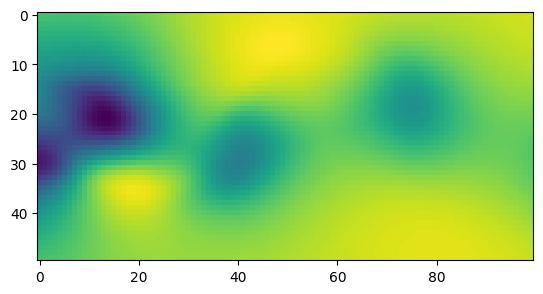

In [ ]:
# 可视化一张压力场图，看一下输出是否合理
hhh = test_output_u[-1, :, -1]
print(hhh.shape)
hhh = hhh.reshape(50, 100)

plt.imshow(hhh)
plt.show()

In [11]:
test_output_grid_u = test_output_u.reshape(200, 50, 100, 3)

u_plot = test_output_grid_u[:, :, :, 0]
v_plot = test_output_grid_u[:, :, :, 1]
p_plot = test_output_grid_u[:, :, :, 2]

In [78]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML   # 关键：把动画嵌进 notebook
# %matplotlib inline

import matplotlib
matplotlib.use('Agg')          # 非交互，不会弹任何图


def draw_animation(field_with_time, frames=20, cmap='jet', save_gif_name=None):

    fig, ax = plt.subplots(figsize=(13, 5))
    plt.contourf(field_with_time[0], levels=30, cmap=cmap)
    plt.colorbar()

    def animate(i):
        ax.clear()
        cax = ax.contourf(field_with_time[i], levels=20, cmap=cmap)
        plt.xlabel(r'$x$')
        plt.ylabel(r'$y$')
        plt.title(r'$p(x,\; y, \; t)$')

    # Call animate method
    ani = FuncAnimation(fig, animate, frames=frames, interval=1, blit=False)
    if save_gif_name is not None:
        ani.save(save_gif_name)
    plt.close(fig)
    return HTML(ani.to_jshtml())


# draw_animation(p_plot, cmap='jet', save_gif_name='p_field.gif')
draw_animation(p_plot, frames=1, cmap='jet')


In [80]:
draw_animation(u_plot, frames=1, cmap='coolwarm')

In [81]:
draw_animation(v_plot, frames=1, cmap='coolwarm')

In [83]:
import numpy as np

def curl_field(u, v, dx=1.0, dy=1.0):
    """
    计算二维速度场 u,v 的旋度 z-分量:  curl = dv/dx - du/dy
    
    参数
    ----
    u, v : ndarray, shape (..., Ny, Nx)
        速度分量，可以是任意 batch 维，但最后两维必须是 [y, x]
    dx, dy : float
        x 和 y 方向的网格间距（默认 1.0，可按实际物理尺度修改）
    
    返回
    ----
    curl : ndarray, same shape as u
        旋度场，维度与输入保持一致
    """
    # dv/dx 沿最后一条轴 (axis=-1)
    dv_dx = np.gradient(v, dx, axis=-1)
    # du/dy 沿倒数第二条轴 (axis=-2)
    du_dy = np.gradient(u, dy, axis=-2)
    return dv_dx - du_dy


# ==================== 使用示例 ====================
# u_plot, v_plot 形状 (200, 50, 100)
curl = curl_field(u_plot, v_plot, dx=1.0, dy=1.0)
# curl 形状仍为 (200, 50, 100)，可直接 contourf/imshow
draw_animation(curl, frames=1, cmap='coolwarm')

In [84]:
fig, ax = plt.subplots(figsize=(13, 5))


x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)
print(X.shape, Y.shape, u_plot[0, ::2, ::2].shape)

plt.contourf(X, Y, curl[0], levels=30, cmap='coolwarm')

plt.quiver(
        X[::2, ::2],
        Y[::2, ::2],
        u_plot[0, ::2, ::2],
        v_plot[0, ::2, ::2],
        color="dimgray",
        scale=50,
        width=0.001
    )

def animate(i):
    ax.clear()
    cax = ax.contourf(X, Y, curl[i], levels=100, cmap='coolwarm')
    plt.xlabel(r'$x$')
    plt.xlabel(r'$y$')
    plt.title(r'curl & streamline')

    cax = ax.quiver(
        X[::2, ::2],
        Y[::2, ::2],
        u_plot[i, ::2, ::2],
        v_plot[i, ::2, ::2],
        color="dimgray",
        scale=50,
        width=0.001
    )

# Call animate method
ani = FuncAnimation(fig, animate, 200, interval=1, blit=False)

# ani.save("curl_field_with_streamline.gif", fps=30)
# 保存成mpv4格式
ani.save("curl_field_with_streamline.mp4", writer='ffmpeg', fps=30, dpi=200) # dpi 提高分辨率
plt.close(fig)


# HTML(ani.to_jshtml())

(50, 100) (50, 100) (25, 50)


# 了解GroundTruth数据格式

In [10]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import matplotlib.animation as animation

data = scipy.io.loadmat('./NS_PINN/cylinder_wake.mat')

In [18]:
data = scipy.io.loadmat('./NS_PINN/cylinder_wake.mat')

U_star = data['U_star']  # N x 2 x T
P_star = data['p_star']  # N x T
t_star = data['t']  # T x 1
X_star = data['X_star']  # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

x_test = X_star[:, 0:1]
y_test = X_star[:, 1:2]
p_test = P_star[:, 0:1]
u_test = U_star[:, 0:1, 0]
t_test = np.ones((x_test.shape[0], x_test.shape[1]))

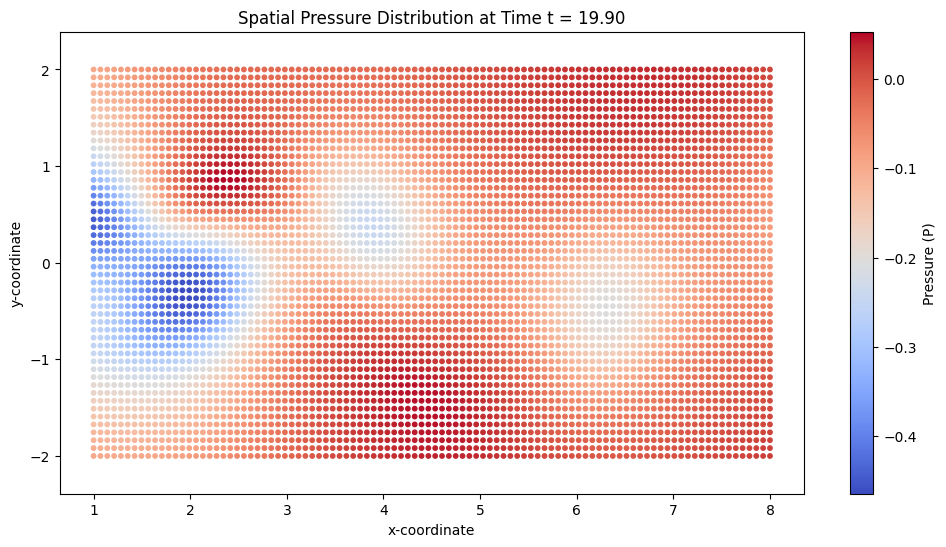

In [20]:
# 假设已经加载了数据: P_star (N x T), X_star (N x 2), t_star (T x 1)
# 确保 T 已定义

# 1. 选择一个时间步
idx_time = T - 1  
current_time = t_star[idx_time].item() # 获取该时间的值

# 2. 提取该时刻所有点的压力值
pressure_spatial = P_star[:, idx_time]

# 3. 绘图 (散点图，颜色代表压力)
plt.figure(figsize=(12, 6))
# 使用 scatter 绘制，cmap 用于颜色映射
sc = plt.scatter(X_star[:, 0], X_star[:, 1], c=pressure_spatial, 
                 cmap='coolwarm', s=10) # s=10 是点的大小，可以调整

# 添加颜色条
cbar = plt.colorbar(sc)
cbar.set_label('Pressure (P)')

plt.title(f'Spatial Pressure Distribution at Time t = {current_time:.2f}')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.axis('equal') # 保持 x 和 y 轴比例一致，流场图常用
plt.show()

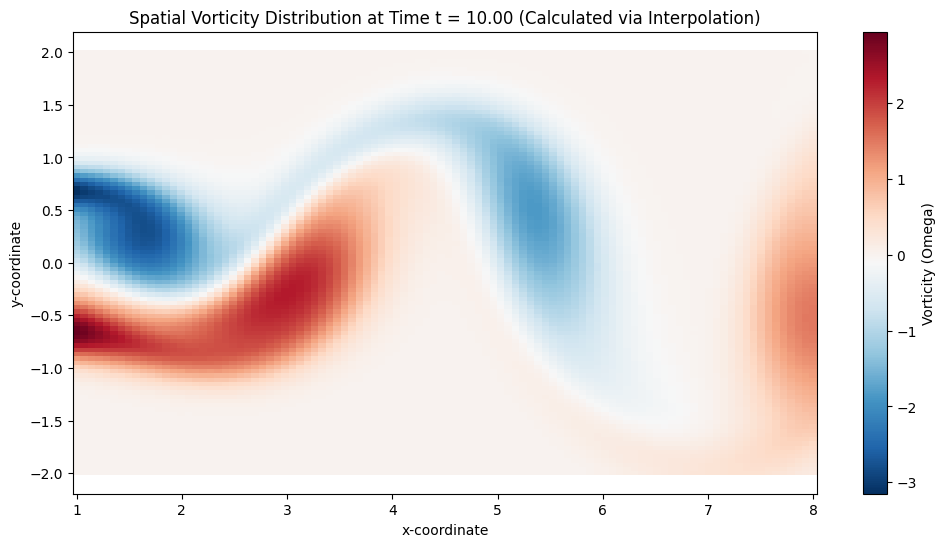

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# --- 假设数据已加载 ---
# P_star (N x T), X_star (N x 2), t_star (T x 1)
# U_star (N x 2 x T)

# 确保 N 和 T 已定义
N = X_star.shape[0]
T = t_star.shape[0]

# 提取速度分量
UU = U_star[:, 0, :]  # N x T
VV = U_star[:, 1, :]  # N x T

# ----------------------------------------------------
# 步骤 1: 选择时间步
# ----------------------------------------------------
idx_time = T - 100  
current_time = t_star[idx_time].item() 

# 提取该时刻的速度场
u_current = UU[:, idx_time] # N x 1
v_current = VV[:, idx_time] # N x 1
points = X_star # N x 2 (x, y 坐标)

# ----------------------------------------------------
# 步骤 2: 创建插值网格
# ----------------------------------------------------
# 定义插值网格的范围 (基于 X_star 的最小/最大值)
xi = np.linspace(points[:, 0].min(), points[:, 0].max(), 100) # x 方向 100 个点
yi = np.linspace(points[:, 1].min(), points[:, 1].max(), 100) # y 方向 100 个点
grid_x, grid_y = np.meshgrid(xi, yi)

# ----------------------------------------------------
# 步骤 3: 使用 griddata 插值 u 和 v 到结构化网格
# ----------------------------------------------------
# 使用线性插值 (linear) 或立方插值 (cubic)
grid_u = griddata(points, u_current, (grid_x, grid_y), method='cubic')
grid_v = griddata(points, v_current, (grid_x, grid_y), method='cubic')

# ----------------------------------------------------
# 步骤 4: 计算偏导数并得到旋度 (Vorticity)
# ----------------------------------------------------
# 使用 np.gradient 计算数值偏导数
# du/dy
du_dy, du_dx = np.gradient(grid_u, yi[1]-yi[0], xi[1]-xi[0]) # 记住：np.gradient 默认返回 (y偏导, x偏导)
# dv/dy, dv/dx
dv_dy, dv_dx = np.gradient(grid_v, yi[1]-yi[0], xi[1]-xi[0]) 

# 计算旋度: omega = dv/dx - du/dy
omega_grid = dv_dx - du_dy 

# ----------------------------------------------------
# 步骤 5: 绘图
# ----------------------------------------------------
plt.figure(figsize=(12, 6))

# 使用 pcolormesh 或 contourf 绘制网格上的旋度
# 绘制颜色图
cf = plt.pcolormesh(grid_x, grid_y, omega_grid, 
                    cmap='RdBu_r', 
                    shading='auto') # RdBu_r 红色和蓝色对比，适用于旋度场

# 添加颜色条
cbar = plt.colorbar(cf)
cbar.set_label('Vorticity (Omega)')

plt.title(f'Spatial Vorticity Distribution at Time t = {current_time:.2f} (Calculated via Interpolation)')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.axis('equal')
plt.show()

#